#### Загружаем библиотеки

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
matplotlib.rcParams.update({'font.size': 14})

#### Загружаем данные и смотрим информацию по данным

In [3]:
DATASET_TRAIN = 'train.csv'
DATASET_TEST = 'test.csv'
df_train = pd.read_csv(DATASET_TRAIN)
df_test = pd.read_csv(DATASET_TEST)
print(df_train.info())
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [5]:
## Добавляем столбец в тестовые данные
df_test['Price'] = 0
df_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B,0
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,0
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B,0
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B,0
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A,0


### Визуализация целевой переменной Price

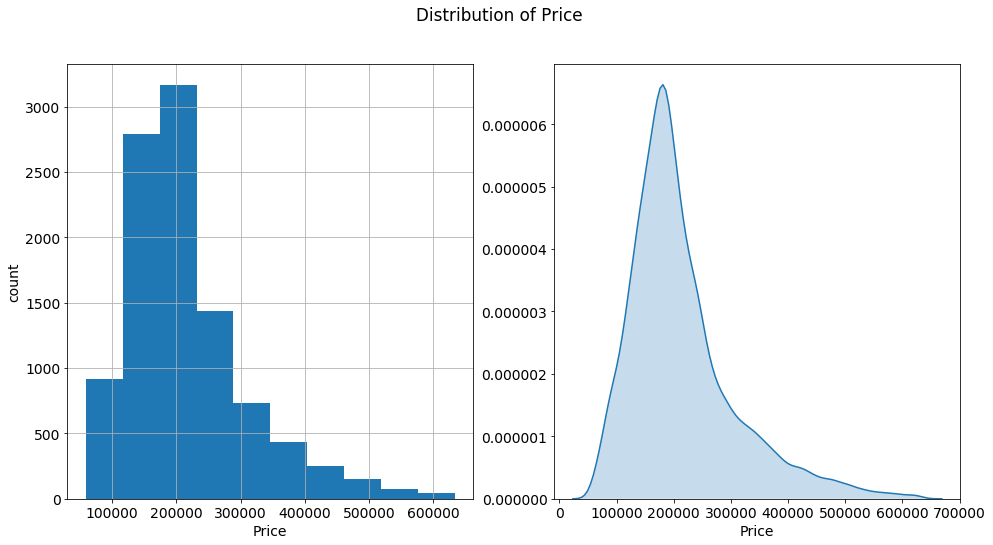

In [6]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
df_train['Price'].hist()
plt.ylabel('count')
plt.xlabel('Price')

plt.subplot(122)
sns.kdeplot(df_train['Price'], shade=True, legend=False)
plt.xlabel('Price')

plt.suptitle('Distribution of Price')
plt.show()

In [7]:
target_mean = round(df_train['Price'].mean(), 2)
target_median = df_train['Price'].median()
target_mode = df_train['Price'].mode()[0]

target_mean, target_median, target_mode

(214138.86, 192269.64487934904, 59174.77802758122)

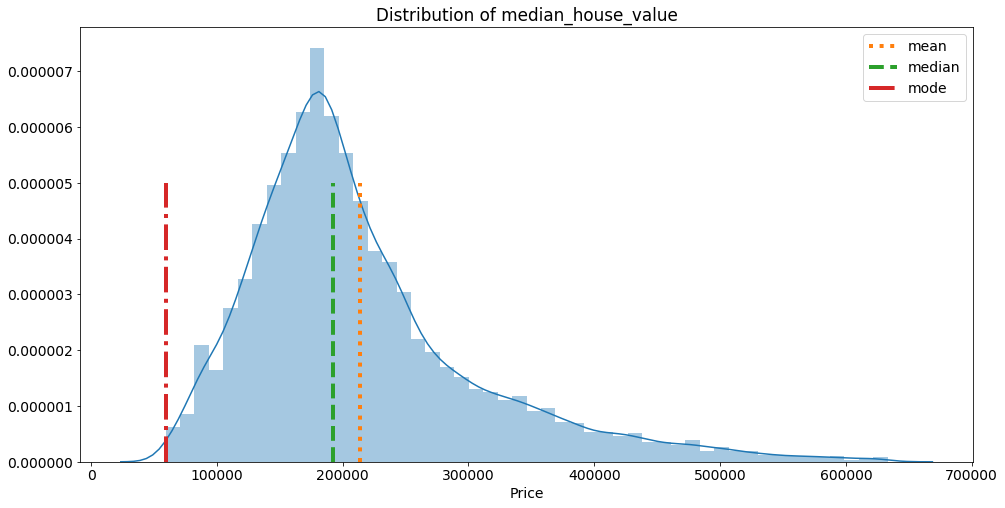

In [8]:
plt.figure(figsize = (16, 8))

sns.distplot(df_train['Price'])

y = np.linspace(0, 0.000005, 100)
plt.plot([target_mean] * 100, y, label='mean', linestyle=':', linewidth=4)
plt.plot([target_median] * 100, y, label='median', linestyle='--', linewidth=4)
plt.plot([target_mode] * 100, y, label='mode', linestyle='-.', linewidth=4)

plt.title('Distribution of median_house_value')
plt.legend()
plt.show()

#### Анализ показателя моды

In [9]:
df_train['Price'].mode()  ## Повторяющиеся значения отсутствуют

0        59174.778028
1        59877.592523
2        60502.583500
3        60825.032060
4        60828.260686
            ...      
9995    624680.099059
9996    625678.644994
9997    625820.041178
9998    627525.072788
9999    633233.466570
Length: 10000, dtype: float64

### Обработка признаков

In [12]:
df = pd.concat([df_train, df_test], axis=0)
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 0 to 4999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             15000 non-null  int64  
 1   DistrictId     15000 non-null  int64  
 2   Rooms          15000 non-null  float64
 3   Square         15000 non-null  float64
 4   LifeSquare     11846 non-null  float64
 5   KitchenSquare  15000 non-null  float64
 6   Floor          15000 non-null  int64  
 7   HouseFloor     15000 non-null  float64
 8   HouseYear      15000 non-null  int64  
 9   Ecology_1      15000 non-null  float64
 10  Ecology_2      15000 non-null  object 
 11  Ecology_3      15000 non-null  object 
 12  Social_1       15000 non-null  int64  
 13  Social_2       15000 non-null  int64  
 14  Social_3       15000 non-null  int64  
 15  Healthcare_1   7825 non-null   float64
 16  Helthcare_2    15000 non-null  int64  
 17  Shops_1        15000 non-null  int64  
 18  Shops_2

#### Анализ показателей типа object: Ecology_2, Ecology_3, Shops_2

In [14]:
df['Ecology_2'].value_counts()

B    14855
A      145
Name: Ecology_2, dtype: int64

In [15]:
df['Ecology_3'].value_counts()

B    14576
A      424
Name: Ecology_3, dtype: int64

In [16]:
df['Shops_2'].value_counts()

B    13763
A     1237
Name: Shops_2, dtype: int64

In [17]:
df.replace({'Ecology_2': {'A': 0, 'B': 1}}, inplace=True)
df.replace({'Ecology_3': {'A': 0, 'B': 1}}, inplace=True)
df.replace({'Shops_2': {'A': 0, 'B': 1}}, inplace=True)

### Обработка признаков

**Количественные признаки**

In [19]:
df_non_binary_features = df[['DistrictId', 
                            'Rooms', 
                            'Square', 
                            'LifeSquare', 
                            'KitchenSquare', 
                            'Floor', 
                            'HouseFloor', 
                            'HouseYear', 
                            'Ecology_1', 
                            'Social_1', 
                            'Social_2', 
                            'Social_3', 
                            'Healthcare_1', 
                            'Helthcare_2', 
                            'Shops_1', 
                            'Price']]
df_non_binary_features.shape

(15000, 16)

In [20]:
df_non_binary_features.corr()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
DistrictId,1.000000,0.063861,-0.030043,-0.021397,0.042293,-0.123774,-0.150007,0.010853,0.070427,0.238062,0.160131,0.134509,0.307696,0.296534,0.168543,0.121846
Rooms,0.063861,1.000000,0.685344,0.152914,0.011596,-0.008179,-0.022225,-0.008731,-0.025705,0.074193,0.070390,0.006296,0.036978,0.052050,0.048053,0.261180
Square,-0.030043,0.685344,1.000000,0.218687,0.012461,0.113981,0.098070,-0.007613,-0.061655,-0.075502,-0.045846,0.025319,-0.046132,-0.036891,0.011542,0.260489
LifeSquare,-0.021397,0.152914,0.218687,1.000000,-0.000882,0.027075,0.032258,-0.002140,-0.023770,-0.049769,-0.039856,0.013081,-0.034083,-0.025998,-0.007327,0.053203
KitchenSquare,0.042293,0.011596,0.012461,-0.000882,1.000000,-0.010622,0.010683,0.000965,-0.003893,0.052472,0.046534,-0.017227,0.011231,0.044913,0.012194,0.021485
Floor,-0.123774,-0.008179,0.113981,0.027075,-0.010622,1.000000,0.434156,0.000703,-0.020034,-0.043501,-0.012720,0.001016,-0.131583,-0.059731,0.030623,0.054690
HouseFloor,-0.150007,-0.022225,0.098070,0.032258,0.010683,0.434156,1.000000,-0.000686,-0.015168,-0.025846,0.003794,-0.014608,-0.149781,-0.072358,0.023358,0.043730
HouseYear,0.010853,-0.008731,-0.007613,-0.002140,0.000965,0.000703,-0.000686,1.000000,0.001166,0.002430,0.001569,0.000640,-0.009705,0.009205,0.003005,0.007204
Ecology_1,0.070427,-0.025705,-0.061655,-0.023770,-0.003893,-0.020034,-0.015168,0.001166,1.000000,0.023236,0.006529,-0.122797,-0.036873,0.028627,-0.076433,-0.031755
Social_1,0.238062,0.074193,-0.075502,-0.049769,0.052472,-0.043501,-0.025846,0.002430,0.023236,1.000000,0.955933,0.022367,0.066335,0.522179,0.527161,0.123805


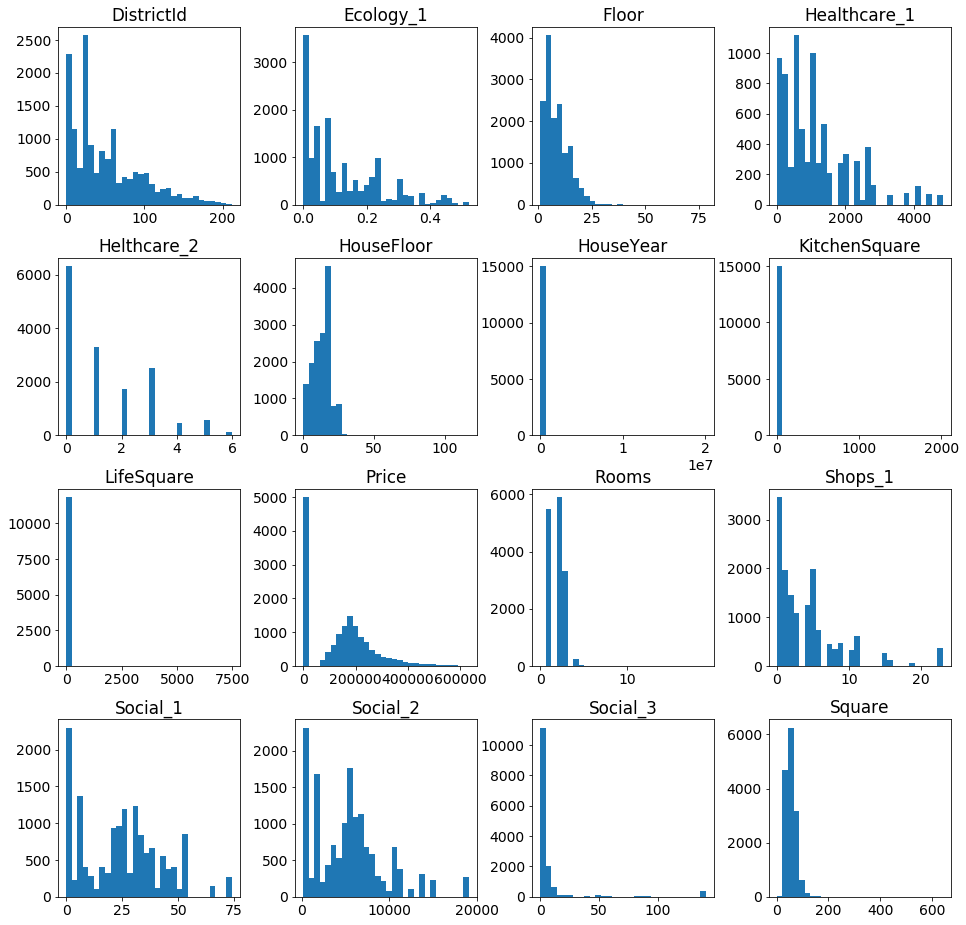

In [21]:
df_non_binary_features.hist(figsize=(16,16), bins=30, grid=False);

##### Судя по гистограмме есть выбросы в HouseFloor, HouseYear, KitchenSquare, LifeSquare, Rooms, Возможно в Square и в Social_3. Проверим сначала Square и Social_3.

In [22]:
df['Square'].describe()

count    15000.000000
mean        56.360350
std         20.423913
min          1.136859
25%         41.814371
50%         52.645757
75%         66.036608
max        641.065193
Name: Square, dtype: float64

##### Проверим значения превышающе медиану примерно в 6 раз, а также менее 10. Cкорее всего значения преувеличены в 10 раз для повышенных значений, и в 10 раз занижены для значений менее 10

In [23]:
df.loc[df['Square'] > 300, :]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
4262,28,9,2.0,604.705972,NaN,1.0,17,18.0,1977,0.161532,1,1,25,5648,1,30.0,2,4,1,187717.242538
4690,2307,102,1.0,409.425181,410.639749,10.0,4,4.0,2016,0.238617,1,1,26,3889,6,705.0,3,6,1,90470.430830
6977,11602,30,2.0,641.065193,638.163193,10.0,20,19.0,2019,0.000078,1,1,22,6398,141,1046.0,3,23,1,133529.681562


In [24]:
df.loc[df['Square'] > 300, ['Square']] = df.loc[df['Square'] > 300, ['Square']] /10
df.loc[df['Square'] > 300, ['Square']]

,Square


In [25]:
df.loc[df['Square'] <= 10]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
212,1748,88,2.0,5.497061,67.628717,1.0,24,22.0,1977,0.127376,1,1,43,8429,3,NaN,3,9,1,412511.088764
1316,11526,27,1.0,4.633498,1.969969,1.0,18,1.0,1977,0.011654,1,1,4,915,0,NaN,0,0,1,107604.269441
1608,10202,6,1.0,2.596351,4.604943,1.0,3,25.0,2014,0.243205,1,1,5,1564,0,540.0,0,0,1,137597.601458
3280,10527,27,1.0,4.380726,40.805837,1.0,10,17.0,2013,0.211401,1,1,9,1892,0,NaN,0,1,1,97560.720383
3413,9487,5,1.0,5.129222,5.549458,1.0,1,1.0,1977,0.150818,1,1,16,3433,4,2643.0,4,5,1,369472.403061
4853,3224,27,0.0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,1,1,2,469,0,NaN,0,0,1,126596.941798
4900,4504,27,3.0,4.390331,5.610772,1.0,8,19.0,2016,0.211401,1,1,9,1892,0,NaN,0,1,1,161379.067034
6392,14786,1,1.0,1.136859,4.525736,1.0,3,1.0,1977,0.007122,1,1,1,264,0,NaN,0,1,1,181434.825589
8030,13265,1,3.0,4.823679,79.767964,0.0,6,17.0,1977,0.007122,1,1,1,264,0,NaN,0,1,1,237716.681261
8283,15744,34,1.0,1.988943,2.642219,1.0,21,4.0,1977,0.069753,1,1,53,13670,4,NaN,1,11,1,458378.777006


In [26]:
df.loc[df['Square'] <= 10, ['Square']] = df.loc[df['Square'] <= 10, ['Square']] * 10
df.loc[df['Square'] <= 10] 

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price


In [27]:
df['Social_3'].describe()

count    15000.000000
mean         8.113667
std         23.841946
min          0.000000
25%          0.000000
50%          2.000000
75%          5.000000
max        141.000000
Name: Social_3, dtype: float64

##### В Social_3 визуально отклонений не нашла

#### Проверим логику данных

In [28]:
df[df['Floor'] > df['HouseFloor']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
7,11993,74,2.0,80.312926,NaN,0.0,14,0.0,1977,0.075779,1,1,6,1437,3,NaN,0,2,1,221244.156664
14,10953,27,1.0,53.769097,52.408027,1.0,5,4.0,1977,0.072158,1,1,2,629,1,NaN,0,0,0,140647.565937
16,2119,27,2.0,49.360648,31.993964,5.0,6,5.0,1983,0.051815,1,1,5,1227,0,NaN,0,0,1,117000.381287
21,11935,27,2.0,64.711835,NaN,1.0,15,1.0,1977,0.211401,1,1,9,1892,0,NaN,0,1,1,127200.026511
23,6641,54,3.0,118.907612,NaN,0.0,2,0.0,1977,0.006076,1,1,30,5285,0,645.0,6,6,1,571069.052600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4976,4723,95,1.0,45.542940,NaN,0.0,6,0.0,1977,0.000699,1,1,14,3369,24,4129.0,0,3,1,0.000000
4989,2591,39,2.0,44.203592,30.191691,6.0,10,9.0,1972,0.428826,1,1,25,5011,8,730.0,0,2,1,0.000000
4993,14562,113,2.0,46.627882,27.058739,5.0,6,5.0,1969,0.307467,1,0,30,5048,9,325.0,2,5,1,0.000000
4997,5783,12,3.0,77.842178,48.282625,9.0,23,22.0,1989,0.090799,1,1,74,19083,2,NaN,5,15,1,0.000000


In [29]:
#Находим коэфф, во сколько раз Floor меньше, чем HouseFloor в корректных объектах
coef_HF = (df[df['Floor'] < df['HouseFloor']]['Floor']/df[df['Floor'] < df['HouseFloor']]['HouseFloor']).median()
# Заменяем все некорректные значения с учетом этого коэффициента
df.loc[df['Floor'] > df['HouseFloor'], 'HouseFloor'] = round(df.loc[df['Floor'] > df['HouseFloor'], 'Floor']/coef_HF)

In [30]:
df[df['Floor'] > df['HouseFloor']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price


In [31]:
df[df['HouseYear'] > 2020]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1497,10814,109,1.0,37.265070,20.239714,9.0,9,12.0,20052011,0.136330,1,1,30,6141,10,262.0,3,6,1,254084.534396
4189,11607,147,2.0,44.791836,28.360393,5.0,4,9.0,4968,0.319809,1,1,25,4756,16,2857.0,5,8,1,243028.603096


In [32]:
groupby_DI = df.groupby("DistrictId")
district_id_median = pd.Series(groupby_DI['HouseYear'].median())
print(district_id_median[109], district_id_median[147])

1979.0 1968.5


In [33]:
df.loc[1497, 'HouseYear'] = 1979
df.loc[4189, 'HouseYear'] = 1968
df[df['HouseYear'] > 2020]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price


In [34]:
df.loc[(df['Rooms'] == 0) | (df['Rooms'] >= 6)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
377,5927,57,10.0,59.056975,36.223072,10.0,22,22.0,2002,0.090799,1,1,74,19083,2,NaN,5,15,1,317265.323792
1397,12638,27,0.0,138.427694,136.215499,0.0,4,7.0,2016,0.075424,1,1,11,3097,0,NaN,0,0,1,268394.744389
1454,8491,1,19.0,42.006046,21.779288,7.0,17,17.0,2014,0.007122,1,1,1,264,0,NaN,0,1,1,78364.616704
1981,7917,27,0.0,212.932361,211.231125,0.0,2,3.0,2008,0.211401,1,1,9,1892,0,NaN,0,1,1,302211.260887
2170,14003,99,6.0,59.414334,38.702244,6.0,7,9.0,1969,0.033494,1,1,66,10573,1,1322.0,3,8,1,229661.964416
2269,7317,27,0.0,41.790881,NaN,0.0,13,23.0,1977,0.211401,1,1,9,1892,0,NaN,0,1,1,98129.976788
3911,770,28,0.0,49.483501,NaN,0.0,16,29.0,2015,0.118537,1,1,30,6207,1,1183.0,1,0,1,217009.338463
4366,456,6,0.0,81.491446,NaN,0.0,4,7.0,1977,0.243205,1,1,5,1564,0,540.0,0,0,1,212864.799112
4853,3224,27,0.0,23.772476,0.873147,0.0,1,2.0,1977,0.017647,1,1,2,469,0,NaN,0,0,1,126596.941798
6149,3159,88,0.0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,1,1,43,8429,3,NaN,3,9,1,158998.110646


In [36]:
#Находим коэфф, во сколько раз Rooms меньше, чем Square в корректных объектах
coef_RM = (df.loc[(df['Rooms'] != 0) | (df['Rooms'] < 6)]['Rooms']/df.loc[(df['Rooms'] != 0) | (df['Rooms'] < 6)]['Square']).median()
# Заменяем все некорректные значения с учетом этого коэффициента
df.loc[(df['Rooms'] == 0) | (df['Rooms'] >= 6), 'Rooms'] = round(df.loc[(df['Rooms'] == 0) | (df['Rooms'] >= 6), 'Square']*coef_RM)

In [37]:
df.loc[(df['Rooms'] == 0) | (df['Rooms'] >= 6)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1981,7917,27,7.0,212.932361,211.231125,0.0,2,3.0,2008,0.211401,1,1,9,1892,0,NaN,0,1,1,302211.260887
3217,4058,27,7.0,223.453689,104.113552,16.0,2,2.0,2017,0.041116,1,1,53,14892,4,NaN,1,4,1,0.000000


In [38]:
df.loc[df['Square'] < (df['KitchenSquare'] + df['LifeSquare']), :]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,1,1,23,5735,3,1084.0,0,5,1,175616.227217
28,8054,23,1.0,42.530043,43.967759,1.0,3,9.0,2014,0.034656,1,1,0,168,0,NaN,0,0,1,95338.198549
44,10521,38,3.0,104.211396,106.340403,0.0,20,36.0,2017,0.060753,1,1,15,2787,2,520.0,0,7,1,435462.048070
48,7596,23,1.0,47.080100,46.807989,12.0,3,9.0,1977,0.014073,1,1,2,475,0,NaN,0,0,1,96029.167877
52,2301,1,2.0,61.400054,65.224603,0.0,17,22.0,2016,0.007122,1,1,1,264,0,NaN,0,1,1,199215.452229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4962,5820,94,1.0,33.680382,34.198977,1.0,10,18.0,1972,0.127376,1,1,43,8429,3,NaN,3,9,1,0.000000
4967,349,34,3.0,88.136651,85.270989,10.0,12,25.0,2016,0.069753,1,1,53,13670,4,NaN,1,11,1,0.000000
4969,4821,74,2.0,82.542507,82.585069,0.0,4,17.0,2015,0.309479,1,1,35,7715,4,990.0,0,6,1,0.000000
4974,5296,52,1.0,44.442218,44.634608,0.0,5,17.0,1977,0.371149,1,1,34,7065,1,750.0,2,5,1,0.000000


In [39]:
df.loc[df['Square'] > (df['KitchenSquare'] + df['LifeSquare']), :].corr()['KitchenSquare']

Id               0.004839
DistrictId       0.073808
Rooms            0.133659
Square           0.302346
LifeSquare       0.109918
KitchenSquare    1.000000
Floor            0.132787
HouseFloor       0.212066
HouseYear        0.219991
Ecology_1       -0.029526
Ecology_2        0.017539
Ecology_3       -0.026518
Social_1         0.166153
Social_2         0.168301
Social_3        -0.050843
Healthcare_1    -0.004407
Helthcare_2      0.068708
Shops_1          0.063004
Shops_2         -0.003245
Price            0.154120
Name: KitchenSquare, dtype: float64

In [40]:
#Находим коэфф, во сколько раз Square больше KitchenSquare в корректных объектах
coef_KS = (df[df['Square'] > (df['KitchenSquare'] + df['LifeSquare'])]['Square']/df[df['Square'] > (df['KitchenSquare'] + df['LifeSquare'])]['KitchenSquare']).median()
coef_KS

7.240583519472581

In [41]:
df[df['Square'] < df['KitchenSquare']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1064,14656,62,1.0,47.100719,46.447960,2014.0,4,7.0,2014,0.072158,1,1,2,629,1,NaN,0,0,0,108337.484207
5149,13703,42,1.0,38.071692,19.723548,73.0,9,10.0,2006,0.158249,1,1,21,5731,0,NaN,1,0,1,160488.033165
7088,6569,27,1.0,38.220258,18.716856,84.0,4,17.0,2018,0.011654,1,1,4,915,0,NaN,0,0,1,99079.960518
8584,14679,81,1.0,32.276663,19.278394,1970.0,6,11.0,1977,0.006076,1,1,30,5285,0,645.0,6,6,1,105539.556275
1964,14594,11,2.0,42.795304,24.223770,620.0,11,14.0,1972,0.038693,1,1,28,6533,1,1015.0,2,5,1,0.000000
2424,10662,29,1.0,25.956829,17.251768,33.0,5,5.0,1973,0.069660,1,1,31,6119,4,NaN,1,2,1,0.000000
3863,3194,29,2.0,43.926987,31.028707,44.0,6,11.0,1964,0.086885,1,1,10,2277,2,1547.0,0,0,1,0.000000
4555,12640,6,2.0,54.629142,31.486308,97.0,4,17.0,2015,0.243205,1,1,5,1564,0,540.0,0,0,1,0.000000


In [42]:
# Заменяем все некорректные значения с учетом этого коэффициента
df.loc[df['Square'] < df['KitchenSquare'], 'KitchenSquare'] = df.loc[df['Square'] < df['KitchenSquare'], 'Square']/coef_KS
df.loc[df['KitchenSquare'] == 0, 'KitchenSquare'] = df.loc[df['KitchenSquare'] == 0, 'Square']/coef_KS

In [43]:
df[df['Square'] < df['LifeSquare'] + df['KitchenSquare']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
3,5809,58,2.0,53.352981,52.731512,9.000000,8,17.0,1977,0.437885,1,1,23,5735,3,1084.0,0,5,1,175616.227217
28,8054,23,1.0,42.530043,43.967759,1.000000,3,9.0,2014,0.034656,1,1,0,168,0,NaN,0,0,1,95338.198549
42,9833,1,2.0,56.494318,54.723569,7.802454,9,17.0,1977,0.007122,1,1,1,264,0,NaN,0,1,1,196078.907289
44,10521,38,3.0,104.211396,106.340403,14.392679,20,36.0,2017,0.060753,1,1,15,2787,2,520.0,0,7,1,435462.048070
48,7596,23,1.0,47.080100,46.807989,12.000000,3,9.0,1977,0.014073,1,1,2,475,0,NaN,0,0,1,96029.167877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4962,5820,94,1.0,33.680382,34.198977,1.000000,10,18.0,1972,0.127376,1,1,43,8429,3,NaN,3,9,1,0.000000
4967,349,34,3.0,88.136651,85.270989,10.000000,12,25.0,2016,0.069753,1,1,53,13670,4,NaN,1,11,1,0.000000
4969,4821,74,2.0,82.542507,82.585069,11.399980,4,17.0,2015,0.309479,1,1,35,7715,4,990.0,0,6,1,0.000000
4974,5296,52,1.0,44.442218,44.634608,6.137933,5,17.0,1977,0.371149,1,1,34,7065,1,750.0,2,5,1,0.000000


In [44]:
#Находим коэфф, во сколько раз Square больше Lifecquare в корректных объектах
coef_LS = (df[df['Square'] - df['KitchenSquare'] > df['LifeSquare']]['Square']/df[df['Square'] - df['KitchenSquare'] >  df['LifeSquare']]['LifeSquare']).median()
coef_LS

1.6542156637622645

In [45]:
# Заменяем все некорректные значения с учетом этого коэффициента
df.loc[df['Square'] - df['KitchenSquare'] < df['LifeSquare'], 'LifeSquare'] = df.loc[df['Square'] - df['KitchenSquare'] < df['LifeSquare'], 'Square']/coef_LS
df.loc[df['LifeSquare'] == 0, 'LifeSquare'] = df.loc[df['LifeSquare'] == 0, 'Square']/coef_LS

In [46]:
df[df['Square'] < df['KitchenSquare']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price


In [47]:
df.loc[df['LifeSquare'].isnull(), 'LifeSquare'] = df.loc[df['LifeSquare'].isnull(), 'Square']/coef_LS

In [48]:
healthcare_1_for_predict = df.loc[df['Healthcare_1'].isnull(), ['DistrictId', 'Social_1', 'Social_2', 'Social_3', 'Helthcare_2']]
healthcare_1_X = df.loc[df['Healthcare_1'].notnull(), ['DistrictId', 'Social_1', 'Social_2', 'Social_3', 'Helthcare_2']]
healthcare_1_y = np.ravel(df.loc[df['Healthcare_1'].notnull(), ['Healthcare_1']])

In [51]:
X_train, X_test, y_train, y_test = train_test_split(healthcare_1_X, healthcare_1_y, test_size=0.3, random_state=151)
rfc = RandomForestClassifier(max_depth=14, n_estimators=200)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
print(accuracy_score(y_test, y_pred))
rfc.fit(healthcare_1_X, healthcare_1_y)
healthcare_1_pred = rfc.predict(healthcare_1_for_predict)
df.loc[df['Healthcare_1'].isnull(), ['Healthcare_1']] = healthcare_1_pred

1.0


In [52]:
df.isnull().sum()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
Price            0
dtype: int64


### Отбор признаков

In [55]:
feature_names = ['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2']
target_name = ['Price']
id_stat = ['Id']

In [56]:
df = df[id_stat + feature_names + target_name]
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.00000,7,9.0,1969,0.089040,1,1,33,7976,5,990.0,0,11,1,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.00000,7,9.0,1978,0.000070,1,1,46,10309,1,240.0,1,16,1,300009.450063
2,4765,53,2.0,44.947953,29.197612,6.20778,8,12.0,1968,0.049637,1,1,34,7759,0,229.0,1,3,1,220925.908524
3,5809,58,2.0,53.352981,32.252736,9.00000,8,17.0,1977,0.437885,1,1,23,5735,3,1084.0,0,5,1,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.00000,11,12.0,1976,0.012339,1,1,35,5776,1,2078.0,2,4,1,150226.531644


##### Разделяем датафреймы

In [57]:
df_test = df.loc[df['Price'] == 0]
df_train = df.loc[df['Price'] != 0]

##### Строим первую модель для определения важности признаков

In [58]:
X_train, X_test, y_train, y_test = train_test_split(df_train[feature_names], df_train[target_name], test_size=0.3)
rf_model_first = RandomForestRegressor(max_depth=16, n_estimators=800)
rf_model_first.fit(X_train, np.ravel(y_train))
y_test_preds = rf_model_first.predict(X_test)
r2(y_test, y_test_preds)

0.7291740742349991

In [59]:
importance = list(zip(rf_model_first.feature_importances_, feature_names))
sorted(importance, reverse=True)

[(0.4025860556817726, 'Square'),
 (0.11677889636040194, 'Social_2'),
 (0.07919218451895212, 'Social_1'),
 (0.06521406502689413, 'Rooms'),
 (0.05708217904968023, 'Social_3'),
 (0.045034862397579235, 'DistrictId'),
 (0.03963265763518054, 'Ecology_1'),
 (0.0372643649181959, 'HouseYear'),
 (0.03256844552005499, 'LifeSquare'),
 (0.026577317448213438, 'HouseFloor'),
 (0.023998368699957397, 'Healthcare_1'),
 (0.023812220381579187, 'Floor'),
 (0.023212658059195052, 'KitchenSquare'),
 (0.01760611280808467, 'Shops_1'),
 (0.007861436341863152, 'Helthcare_2'),
 (0.0009095724090669554, 'Shops_2'),
 (0.000400274886555698, 'Ecology_3'),
 (0.00026832785677288144, 'Ecology_2')]

In [60]:
## importance_features = ['Square', 'Social_2', 'Social_1', 'Social_3', 'DistrictId', 'Ecology_1', 'Healthcare_1', 'HouseYear', 'KitchenSquare', 'Floor', 'Shops_1']
## 0.7680128698078499
## importance_features = ['Square', 'Social_2', 'Social_1', 'Rooms', 'Social_3', 'DistrictId', 'Ecology_1', 'Healthcare_1', 'HouseYear', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'Shops_1']
## 0.7711872889716269
## importance_features = ['Square', 'Social_2', 'Social_1', 'Social_3', 'DistrictId', 'Ecology_1', 'Healthcare_1', 'HouseYear', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'Shops_1']
## 0.7718811290795857

In [61]:
importance_features = ['Square', 'Social_2', 'Social_1', 'Social_3', 'DistrictId', 'Ecology_1', 'Healthcare_1', 'HouseYear', 'KitchenSquare', 'Floor', 'HouseFloor', 'Shops_1']
## 0.7730452150948681

##### Делим датафрейм на тестовые и тренировочные данные

In [62]:
X_train, X_test, y_train, y_test = train_test_split(df_train[importance_features], df_train['Price'], random_state = 151, test_size=0.3)

###### Находим лучшие настройки модели

In [63]:
## parameters = {
##     'n_estimators': [150, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
##     'max_depth': np.arange(5, 30),
## }

## clf = GridSearchCV(
##     estimator=RandomForestRegressor(),
##     param_grid=parameters,
##     scoring='r2',
##     cv=5,
## )
## clf.fit(X_train, y_train)
## clf.best_params_

## {'max_depth': 16, 'n_estimators': 700}

In [69]:
rf_model = RandomForestRegressor(max_depth=16, n_estimators=800, random_state = 65)
rf_model.fit(X_train, np.ravel(y_train))
y_test_preds = rf_model.predict(X_test)

print(f' max_depth=16, n_estimators=300 r2_test: {r2(y_test, y_test_preds)}')

 max_depth=16, n_estimators=300 r2_test: 0.77417125511857


In [70]:
## for i in range(200):
##     rf_model = RandomForestRegressor(max_depth=16, n_estimators=800, random_state=i)
##     rf_model.fit(X_train, np.ravel(y_train))
##     y_test_preds = rf_model.predict(X_test)
##     if r2(y_test, y_test_preds) >= 0.773:
##         print(f'{i} r2_test: {r2(y_test, y_test_preds)}')

## 65 r2_test: 0.77417125511857

In [71]:
rf_model.fit(df_train[importance_features], df_train['Price'])

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=16, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=800, n_jobs=None, oob_score=False,
                      random_state=65, verbose=0, warm_start=False)

In [72]:
y_test_preds_res = rf_model.predict(df_test[importance_features])
y_test_preds_res

array([157478.87739432, 229553.47456288, 137567.82706971, ...,
       339850.40924872, 206400.08932103, 181856.11932527])

In [73]:
df_test['Price'] = y_test_preds_res
df_test

D:\Anakonda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,725,58,2.0,49.882643,33.432782,6.000000,6,14.0,1972,0.310199,1,1,11,2748,1,32.0,0,0,1,157478.877394
1,15856,74,2.0,69.263183,41.870709,1.000000,6,11.0,1977,0.075779,1,1,6,1437,3,1084.0,0,2,1,229553.474563
2,5480,190,1.0,13.597819,8.220100,12.000000,2,5.0,1909,0.000000,1,1,30,7538,87,4702.0,5,5,1,137567.827070
3,15664,47,2.0,73.046609,51.940842,9.000000,22,22.0,2007,0.101872,1,1,23,4583,3,1084.0,3,3,1,339744.946261
4,14275,27,1.0,47.527111,43.387569,1.000000,17,17.0,2017,0.072158,1,1,2,629,1,0.0,0,0,0,144129.203258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,8180,11,3.0,67.133911,50.809797,6.000000,5,9.0,1973,0.000170,1,1,36,5992,0,2078.0,1,1,1,243900.106835
4996,4695,1,1.0,40.198472,21.807061,10.000000,12,17.0,2017,0.007122,1,1,1,264,0,0.0,0,1,1,137487.624320
4997,5783,12,3.0,77.842178,48.282625,9.000000,23,41.0,1989,0.090799,1,1,74,19083,2,1322.0,5,15,1,339850.409249
4998,4780,62,2.0,81.305222,49.150316,11.229098,4,7.0,1977,0.072158,1,1,2,629,1,35.0,0,0,0,206400.089321


In [74]:
RES_DATASET_PATH = 'SShirkin_predictions.csv'
df_test[['Id', 'Price']].to_csv(RES_DATASET_PATH, index=None, encoding='utf-8')